In [1]:
#!pip install yfinance

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers.legacy import Adam

In [2]:
# System Constants
Epoch_count = 50
Batch_size = 32

In [3]:
walmart_price_data = yf.Ticker("WMT")
walmart_historical_data = walmart_price_data.history(period="max")

In [4]:
#Having a look at the closing price data of the stocks
# Get closing price column from the dataframe
closing_price_walmart = walmart_historical_data.iloc[:,3:4]
closing_price_walmart = closing_price_walmart.rename(columns={"Close": "Closing Price"})
closing_price_walmart.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.035475
1972-08-28 00:00:00-04:00,0.035341
1972-08-29 00:00:00-04:00,0.034938
1972-08-30 00:00:00-04:00,0.034938
1972-08-31 00:00:00-04:00,0.034400


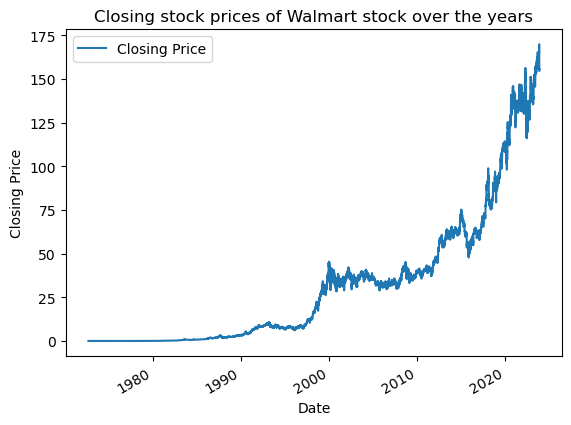

In [5]:
# Plotting the closing stock price data
closing_price_walmart.plot()
plt.ylabel("Closing Price")
plt.title("Closing stock prices of Walmart stock over the years")
plt.show()

In [6]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_walmart_scaled = scaler.fit_transform(closing_price_walmart)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_walmart.isna()) == len(closing_price_walmart)
closing_price_walmart_scaled_df = pd.DataFrame(closing_price_walmart_scaled)
closing_price_walmart_scaled_df.index = closing_price_walmart.index
closing_price_walmart_scaled_df = closing_price_walmart_scaled_df.rename(columns={0:"Closing Price"})
closing_price_walmart_scaled_df.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.000158
1972-08-28 00:00:00-04:00,0.000157
1972-08-29 00:00:00-04:00,0.000155
1972-08-30 00:00:00-04:00,0.000155
1972-08-31 00:00:00-04:00,0.000152


In [7]:
def get_data_splits(data, train_size=20, label_count=1):
    
    # Initialize empty arrays for training sets and labels
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))

    # Calculate the length of the input data
    length = len(data)

    # Iterate through the data to create training sets and labels
    for i in range(0, length):
        # Check if extending the current index by train_size exceeds the data length
        if (i + train_size) >= length:
            break

        # Append a reshaped training sequence to the train_sets array
        train_sequence = data[i:(i + train_size)].reshape(train_size,)
        train_sets = np.append(train_sets, [train_sequence], axis=0)

        # Append the corresponding label sequence to the labels array
        label_sequence = data[(i + train_size):(i + train_size + label_count)].reshape(label_count,)
        labels = np.append(labels, [label_sequence], axis=0)

    # Reshape the arrays for compatibility with machine learning models
    reshaped_train_sets = train_sets.reshape(len(train_sets), train_size, 1)
    reshaped_labels = labels.reshape(len(labels), label_count, 1)

    return reshaped_train_sets, reshaped_labels

In [8]:
# Splitting the dataset
length = len(closing_price_walmart_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_walmart = closing_price_walmart_scaled[0:train_sample_count]
validation_walmart = closing_price_walmart_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_walmart = closing_price_walmart_scaled[(
    train_sample_count + val_sample_count):length]

In [9]:
len(training_walmart), len(validation_walmart), len(testing_walmart)

(7753, 2584, 2585)

In [10]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_walmart, train_size, label_count)
X_val, y_val = get_data_splits(validation_walmart, train_size, label_count)
X_test, y_test = get_data_splits(testing_walmart, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7733 7733
2564 2564
2565 2565


In [11]:
def plot_training_history_curve(fitted_model):
    """Plot training/validation loss and accuracy curve."""
    history_df = pd.DataFrame(fitted_model.history)
    history_df.plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted_values(y_train, y_test, train_predict, test_predict, second_stock_y=np.array([])):
    """Plot actual and predicted values."""
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)

    plt.figure(figsize=(15, 8), dpi=80)

    plt.plot(range(rows), actual, label='Actual')
    plt.plot(range(rows), predictions, label='Predictions')

    if len(second_stock_y) != 0:
        plt.plot(range(rows), second_stock_y, label='COST')

    plt.legend()
    plt.axvline(x=len(y_train), color='r')
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

    plt.show()

### Baseline GRU Creation

In [12]:
def create_base_GRU(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=lr))
    return model

n_hidden_units_gru = 64
n_dense_units_gru = 1
input_shape_gru = (train_size, 1)

# Create base GRU model
base_gru = create_base_GRU(n_hidden_units_gru, n_dense_units_gru,
                                input_shape_gru, activation='tanh')
base_gru.summary()

# Training the base GRU
with tf.device('/cpu:0'):
    fitted_base_gru = base_gru.fit(X_train, y_train, validation_data=(X_val, y_val),
                                       batch_size=Batch_size, epochs=Epoch_count)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 1.8202e-04 - val_loss: 2.2370e-05
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 8.2173e-06 - val_loss: 3.5392e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 7.8924e-06 - val_loss: 3.8318e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 7.9957e-06 - val_l

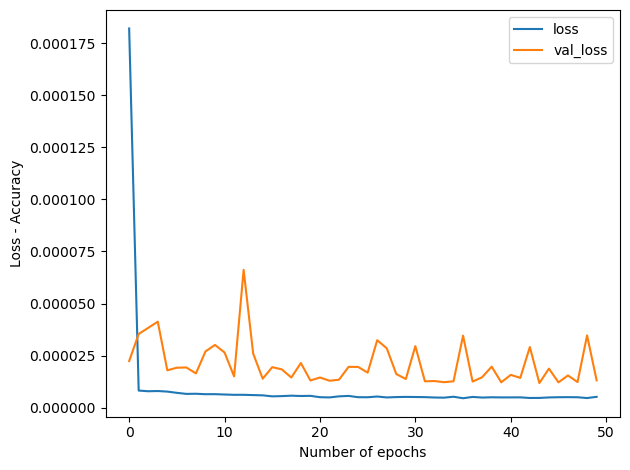

In [13]:
plot_training_history_curve(fitted_base_gru)

81/81 [==============================] - 0s 795us/step


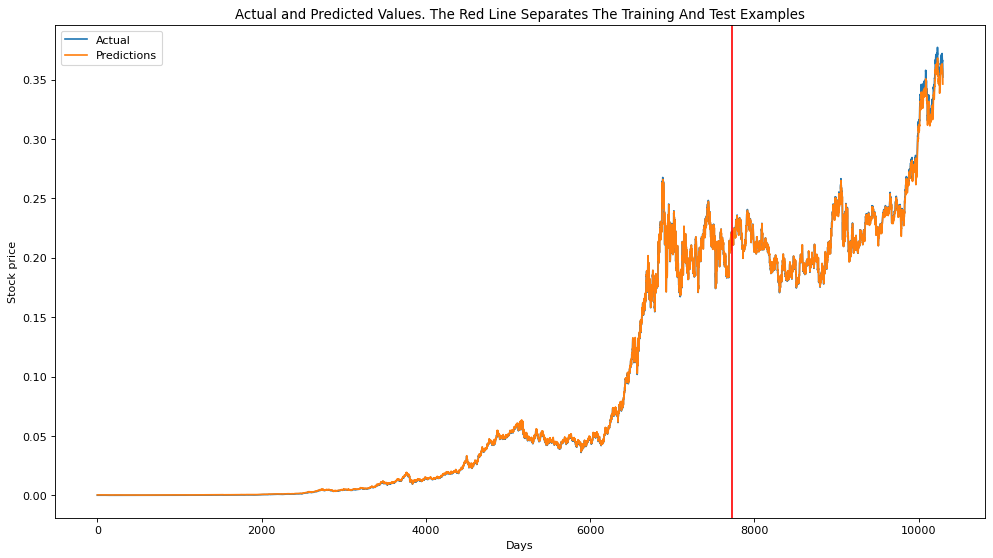

In [14]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_base_gru = fitted_base_gru.model.predict(X_train)
    val_predict_base_gru = fitted_base_gru.model.predict(X_val)

plot_actual_vs_predicted_values(y_train, y_val, train_predict_base_gru, val_predict_base_gru)

In [15]:
# Experimentation on base GRU, Adding more layers

# Creating RNN with multiple layers
def create_multilayered_GRU(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    
    for i, units in enumerate(hidden_units_list):
        return_sequences = i < len(hidden_units_list) - 1
        model.add(GRU(units, input_shape=input_shape, activation=activation, return_sequences=return_sequences))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.legacy.Adam(learning_rate=lr))
    return model

n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

In [16]:
multilayered_gru = create_multilayered_GRU(n_hidden_units_list, n_dense_units,
                                           input_shape, activation='tanh')
multilayered_gru.summary()

# Training the multilayered GRU
with tf.device('/cpu:0'):
    fitted_multilayered_gru = multilayered_gru.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=Batch_size, epochs=Epoch_count)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 20, 64)            12864     
                                                                 
 gru_2 (GRU)                 (None, 20, 64)            24960     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62849 (245.50 KB)
Trainable params: 62849 (245.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 4s 11ms/step - loss: 1.7356e-04 - val_loss: 3.6527e-05
Epoch 2/50
242/242 [===================

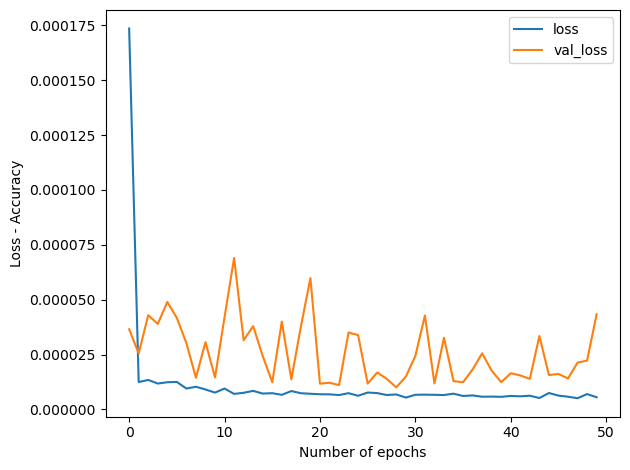

In [17]:
plot_training_history_curve(fitted_multilayered_gru)

81/81 [==============================] - 0s 2ms/step


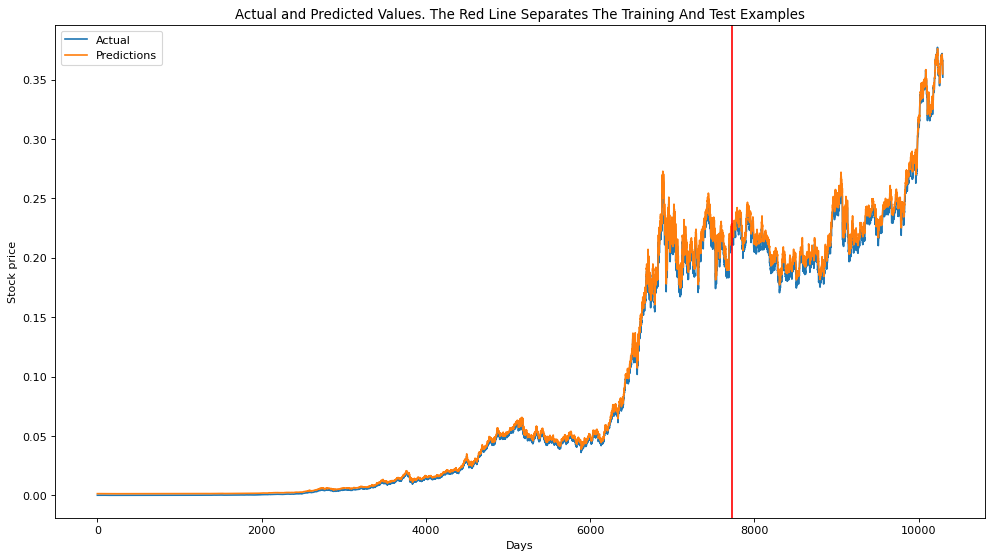

In [18]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_multilayered_gru = fitted_multilayered_gru.model.predict(X_train)
    val_predict_multilayered_gru = fitted_multilayered_gru.model.predict(X_val)

plot_actual_vs_predicted_values(y_train, y_val, train_predict_multilayered_gru, val_predict_multilayered_gru)

In [19]:
# Experimenting with the activation function and learning rate scheduling techniques

# Function to experiment with optimizer and learning rate
def create_GRU_with_optimizer(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = keras.optimizers.legacy.Adam() if optimizer == "Adam" else keras.optimizers.legacy.RMSprop()

    model.compile(loss='mean_squared_error', optimizer=optimizing_function)
    return model

initial_learning_rate = 0.01
time_decay = initial_learning_rate / Epoch_count

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
                   keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [20]:
# Running the simple GRU model with RMSProp and Adam with 3 different types of learning rate scheduling
n_hidden_units = 64
n_dense_units = 1
results_simple_gru = []

optimizers = ["Adam", "RMSProp"]
for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        model = create_GRU_with_optimizer(n_hidden_units, n_dense_units,
                                        input_shape, activation='tanh', optimizer=optimizer)

        # Training the GRU with multiple layers
        fitted_model = 0
        with tf.device('/cpu:0'):
            if i == 0:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=Batch_size, epochs=Epoch_count)
            else:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=Batch_size, epochs=Epoch_count, callbacks=[callbacks_decay[i - 1]])

        predictions = fitted_model.model.predict(X_val)
        val_mse = mean_squared_error(
            y_val.reshape(y_val.shape[0], 1), predictions)
        results_simple_gru.append(
            (optimizer, callback_decay_keys[i], val_mse))

Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 3.3410e-04 - val_loss: 5.1637e-05
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 9.9233e-06 - val_loss: 2.2253e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 9.7153e-06 - val_loss: 2.0015e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 9.0217e-06 - val_loss: 2.8621e-05
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 8.6373e-06 - val_loss: 2.3734e-05
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 8.7418e-06 - val_loss: 3.6181e-05
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 8.1254e-06 - val_loss: 1.8603e-05
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 7.9077e-06 - val_loss: 3.5124e-05
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 6.8201e-06 - val_loss: 2.7715e-05
Epoch 10/50
242/242 [=======

242/242 [==============================] - 1s 3ms/step - loss: 5.7124e-06 - val_loss: 1.2579e-05 - lr: 0.0050

Epoch 16: LearningRateScheduler setting learning rate to 0.005.
Epoch 16/50
242/242 [==============================] - 1s 3ms/step - loss: 6.4286e-06 - val_loss: 1.8952e-05 - lr: 0.0050

Epoch 17: LearningRateScheduler setting learning rate to 0.005.
Epoch 17/50
242/242 [==============================] - 1s 3ms/step - loss: 5.6805e-06 - val_loss: 1.0700e-05 - lr: 0.0050

Epoch 18: LearningRateScheduler setting learning rate to 0.005.
Epoch 18/50
242/242 [==============================] - 1s 3ms/step - loss: 7.9841e-06 - val_loss: 1.0533e-05 - lr: 0.0050

Epoch 19: LearningRateScheduler setting learning rate to 0.005.
Epoch 19/50
242/242 [==============================] - 1s 3ms/step - loss: 5.4399e-06 - val_loss: 1.2125e-05 - lr: 0.0050

Epoch 20: LearningRateScheduler setting learning rate to 0.005.
Epoch 20/50
242/242 [==============================] - 1s 3ms/step - loss: 7.


Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 4.9737e-06 - val_loss: 1.0560e-05 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 5.2763e-06 - val_loss: 3.9752e-05 - lr: 0.0045

Epoch 10: LearningRateScheduler setting learning rate to 0.004065696597405992.
Epoch 10/50
242/242 [==============================] - 1s 3ms/step - loss: 5.1130e-06 - val_loss: 2.7925e-05 - lr: 0.0041

Epoch 11: LearningRateScheduler setting learning rate to 0.0036787944117144234.
Epoch 11/50
242/242 [==============================] - 1s 3ms/step - loss: 5.1717e-06 - val_loss: 1.4684e-05 - lr: 0.0037

Epoch 12: LearningRateScheduler setting learning rate to 0.003328710836980796.
Epoch 12/50
242/242 [==============================] - 1s 3ms/step - loss: 4.8802e-06 - val_loss: 1.1977e-05 - lr: 


Epoch 48: LearningRateScheduler setting learning rate to 9.095277101695816e-05.
Epoch 48/50
242/242 [==============================] - 1s 3ms/step - loss: 3.9677e-06 - val_loss: 1.0879e-05 - lr: 9.0953e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.229747049020023e-05.
Epoch 49/50
242/242 [==============================] - 1s 3ms/step - loss: 3.9261e-06 - val_loss: 1.2360e-05 - lr: 8.2297e-05

Epoch 50: LearningRateScheduler setting learning rate to 7.446583070924338e-05.
Epoch 50/50
81/81 [==============================] - 0s 841us/step
Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 1.8070e-04 - val_loss: 1.6855e-04
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 4.4134e-05 - val_loss: 5.2951e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 3.5047e-05 - val_loss: 3.7837e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 2.9008e-05 - val_loss: 9.2953e-05
Epoch 

Epoch 12/50
242/242 [==============================] - 1s 3ms/step - loss: 2.2336e-05 - val_loss: 2.4210e-04 - lr: 0.0050

Epoch 13: LearningRateScheduler setting learning rate to 0.005.
Epoch 13/50
242/242 [==============================] - 1s 3ms/step - loss: 2.2655e-05 - val_loss: 3.0418e-04 - lr: 0.0050

Epoch 14: LearningRateScheduler setting learning rate to 0.005.
Epoch 14/50
242/242 [==============================] - 1s 3ms/step - loss: 2.1802e-05 - val_loss: 5.7875e-05 - lr: 0.0050

Epoch 15: LearningRateScheduler setting learning rate to 0.005.
Epoch 15/50
242/242 [==============================] - 1s 3ms/step - loss: 2.2199e-05 - val_loss: 6.5210e-05 - lr: 0.0050

Epoch 16: LearningRateScheduler setting learning rate to 0.005.
Epoch 16/50
242/242 [==============================] - 1s 3ms/step - loss: 2.1212e-05 - val_loss: 4.9034e-05 - lr: 0.0050

Epoch 17: LearningRateScheduler setting learning rate to 0.005.
Epoch 17/50
242/242 [==============================] - 1s 3ms/ste

Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 6.4063e-05 - val_loss: 1.9235e-04 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 4.8086e-05 - val_loss: 3.6899e-05 - lr: 0.0061

Epoch 7: LearningRateScheduler setting learning rate to 0.005488116360940264.
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 3.7685e-05 - val_loss: 2.6194e-05 - lr: 0.0055

Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 3.0141e-05 - val_loss: 8.7273e-05 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 2.4496e-05 - val_loss: 2.5466e-04 - lr: 0.0045

Epoch 10: LearningRateScheduler setting learning rate to 0.004065696597405992.

242/242 [==============================] - 1s 3ms/step - loss: 3.8826e-06 - val_loss: 3.8984e-05 - lr: 1.2277e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.00011108996538242307.
Epoch 46/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8756e-06 - val_loss: 3.5015e-05 - lr: 1.1109e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.00010051835744633576.
Epoch 47/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8726e-06 - val_loss: 3.5190e-05 - lr: 1.0052e-04

Epoch 48: LearningRateScheduler setting learning rate to 9.095277101695816e-05.
Epoch 48/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8590e-06 - val_loss: 3.2691e-05 - lr: 9.0953e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.229747049020023e-05.
Epoch 49/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8482e-06 - val_loss: 3.4164e-05 - lr: 8.2297e-05

Epoch 50: LearningRateScheduler setting learning rate t

In [21]:
columns = ["Optimizer", "Decay type", "Val MSE"]
lstm_results_dataframe = pd.DataFrame(results_simple_gru, columns=columns)
lstm_results_dataframe

,Optimizer,Decay type,Val MSE
0,Adam,constant,0.000012
1,Adam,step_decay,0.000013
2,Adam,exp_decay,0.000011
3,RMSProp,constant,0.000016
4,RMSProp,step_decay,0.000050
5,RMSProp,exp_decay,0.000034


In [22]:
# Based on the above results, Adam with either of constant learning rate, or step_decay or exp_decay will be best

# Choose Adam with step_decay to optimize the GRU model
optimized_gru_constant_lr = create_GRU_with_optimizer(n_hidden_units, n_dense_units,
                               input_shape, activation='tanh', optimizer=keras.optimizers.legacy.Adam())

with tf.device('/cpu:0'):
    fitted_optimized_gru_constant_lr = optimized_gru_constant_lr.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=Batch_size, epochs=Epoch_count)

Epoch 1/50
242/242 [==============================] - 1s 3ms/step - loss: 3.0430e-04 - val_loss: 2.6101e-04
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 5.3103e-05 - val_loss: 2.5876e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8043e-05 - val_loss: 5.2769e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 2.9876e-05 - val_loss: 1.8225e-05
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 2.6260e-05 - val_loss: 2.5643e-05
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 2.1285e-05 - val_loss: 2.9226e-05
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 2.0617e-05 - val_loss: 1.3587e-05
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 1.9339e-05 - val_loss: 6.6700e-05
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 1.7384e-05 - val_loss: 6.0863e-05
Epoch 10/50
242/242 [=======

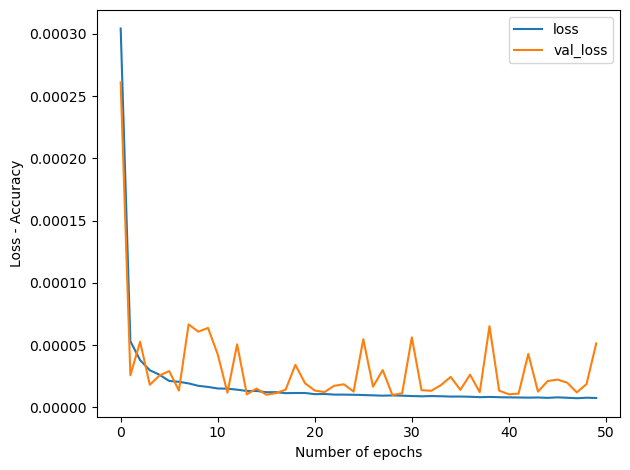

In [23]:
plot_training_history_curve(fitted_optimized_gru_constant_lr)

81/81 [==============================] - 0s 788us/step


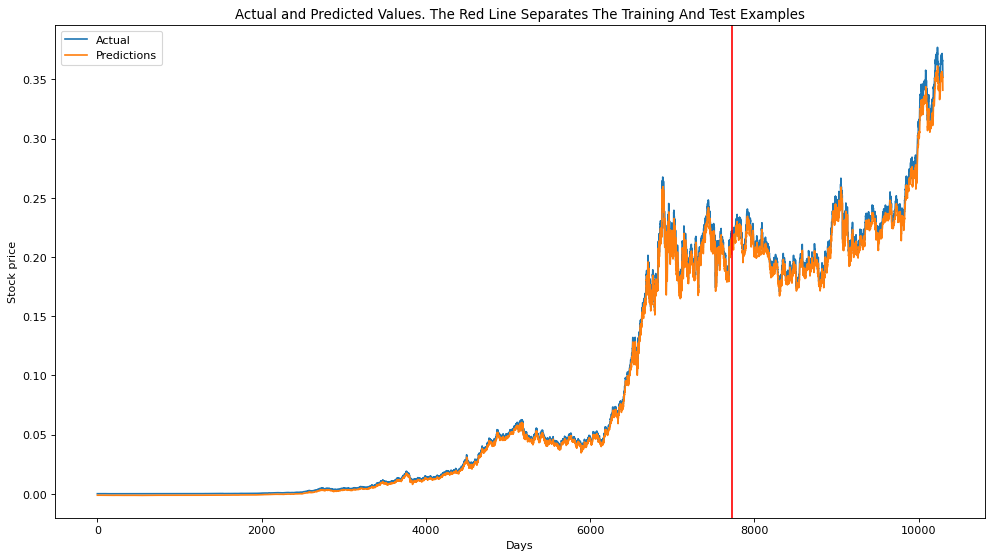

In [24]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_gru_with_optimizer = fitted_optimized_gru_constant_lr.model.predict(X_train)
    val_predict_gru_with_optimizer = fitted_optimized_gru_constant_lr.model.predict(X_val)

plot_actual_vs_predicted_values(y_train, y_val, train_predict_gru_with_optimizer, val_predict_gru_with_optimizer)

In [25]:
# Performance Metrics

# Get training and validation MSEs for all variations of the GRU
train_mse_base_gru, val_mse_base_gru = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_base_gru), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_base_gru)

train_mse_multilayered_gru, val_mse_mulilayered_gru = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_multilayered_gru), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_multilayered_gru)

train_mse_optimized_gru_constant_lr, val_mse_optimized_gru_constant_lr = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_gru_with_optimizer), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_gru_with_optimizer)


In [26]:
# Define a list of tuples for RNN summary
summary_list_gru = [
    ("Base GRU", train_mse_base_gru, val_mse_base_gru),
    ("Stacked GRU", train_mse_multilayered_gru, val_mse_mulilayered_gru),
    ("Optimized GRU", train_mse_optimized_gru_constant_lr, val_mse_optimized_gru_constant_lr)
]

# Create a DataFrame for RNN summary
summary_dataframe = pd.DataFrame(summary_list_gru, columns=["Model", "Train MSE", "Val MSE"])
summary_dataframe

,Model,Train MSE,Val MSE
0,Base GRU,0.000004,0.000013
1,Stacked GRU,0.000013,0.000043
2,Optimized GRU,0.000010,0.000051


(7703, 50, 1) (7703, 1, 1)
(2534, 50, 1) (2534, 1, 1)
Epoch 1/50
241/241 [==============================] - 8s 28ms/step - loss: 1.3328e-04 - val_loss: 4.9152e-05
Epoch 2/50
241/241 [==============================] - 6s 26ms/step - loss: 1.2069e-05 - val_loss: 4.9184e-05
Epoch 3/50
241/241 [==============================] - 7s 29ms/step - loss: 1.4827e-05 - val_loss: 3.0681e-05
Epoch 4/50
241/241 [==============================] - 7s 29ms/step - loss: 1.1930e-05 - val_loss: 2.1000e-05
Epoch 5/50
241/241 [==============================] - 6s 27ms/step - loss: 1.1603e-05 - val_loss: 1.7381e-05
Epoch 6/50
241/241 [==============================] - 7s 29ms/step - loss: 1.0937e-05 - val_loss: 8.1766e-05
Epoch 7/50
241/241 [==============================] - 7s 29ms/step - loss: 1.3491e-05 - val_loss: 1.5958e-05
Epoch 8/50
241/241 [==============================] - 7s 30ms/step - loss: 8.9284e-06 - val_loss: 1.4401e-05
Epoch 9/50
241/241 [==============================] - 7s 29ms/step - loss:

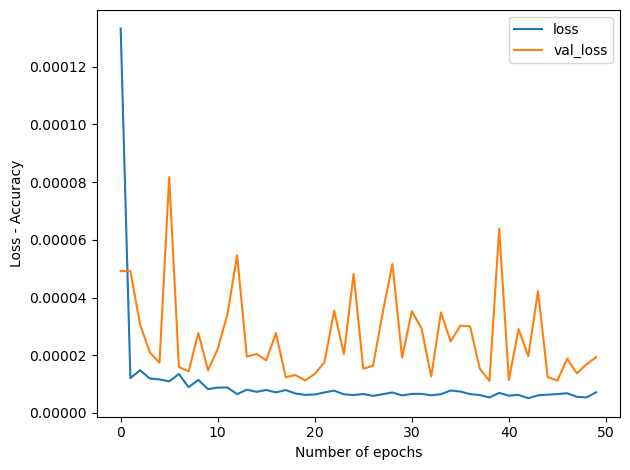

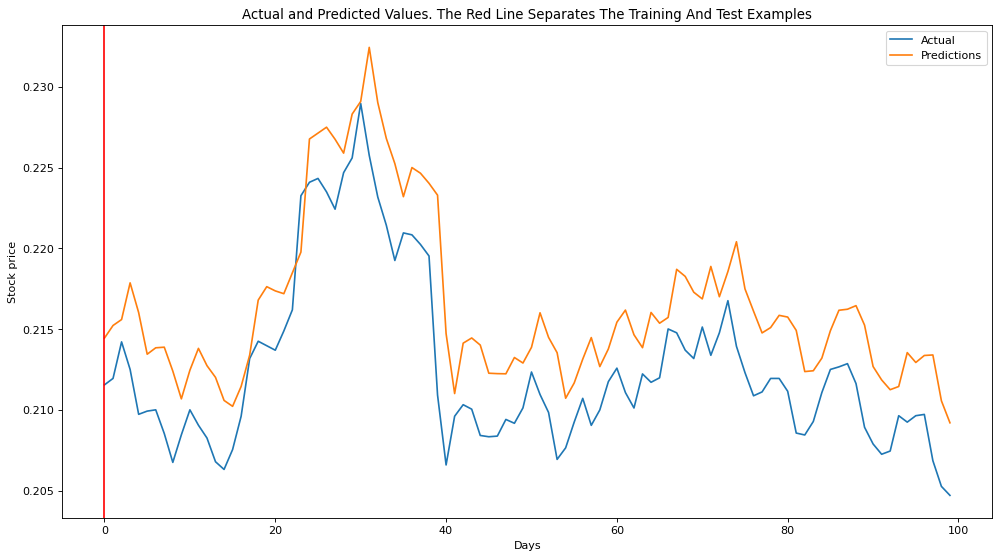

Val MSE = 1.935417213337128e-05
(7653, 100, 1) (7653, 1, 1)
(2484, 100, 1) (2484, 1, 1)
Epoch 1/50
240/240 [==============================] - 15s 55ms/step - loss: 1.3637e-04 - val_loss: 3.2770e-05
Epoch 2/50
240/240 [==============================] - 13s 52ms/step - loss: 1.5418e-05 - val_loss: 7.5543e-05
Epoch 3/50
240/240 [==============================] - 13s 53ms/step - loss: 1.3558e-05 - val_loss: 2.1512e-04
Epoch 4/50
240/240 [==============================] - 13s 55ms/step - loss: 1.2754e-05 - val_loss: 6.5860e-05
Epoch 5/50
240/240 [==============================] - 14s 57ms/step - loss: 1.4226e-05 - val_loss: 7.7287e-05
Epoch 6/50
240/240 [==============================] - 14s 57ms/step - loss: 1.3372e-05 - val_loss: 5.8364e-05
Epoch 7/50
240/240 [==============================] - 14s 59ms/step - loss: 9.2905e-06 - val_loss: 6.2005e-05
Epoch 8/50
240/240 [==============================] - 14s 59ms/step - loss: 1.0417e-05 - val_loss: 3.7204e-05
Epoch 9/50
240/240 [============

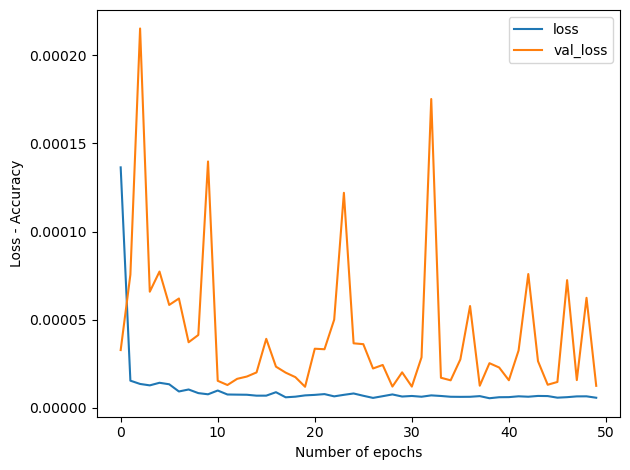

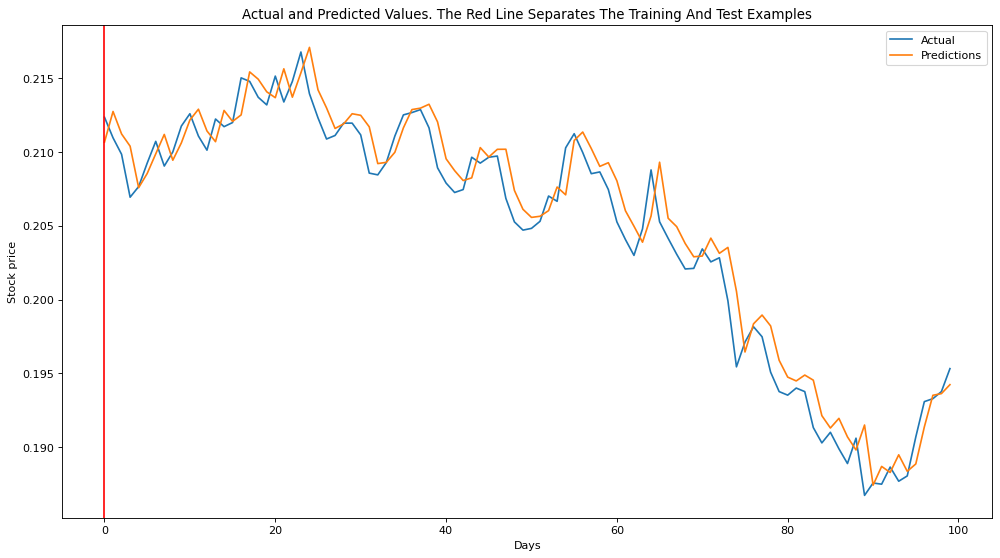

Val MSE = 1.2494221065170158e-05


In [50]:
# Experimenting with window size

# Get the train features, train labels, test features, test labels
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    X_train_exp, y_train_exp = get_data_splits(
        training_walmart, train_size, label_count)
    X_val_exp, y_val_exp = get_data_splits(
        validation_walmart, train_size, label_count)
    
    #display data shapes
    print(X_train_exp.shape, y_train_exp.shape)
    print(X_val_exp.shape, y_val_exp.shape)

    # Create and train RNN model
    model_exp = create_multilayered_GRU([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                              (train_size, 1), activation='tanh')
    with tf.device('/cpu:0'):
        # Train the model
        fitted_model_exp = model_exp.fit(X_train_exp, y_train_exp, validation_data=(
            X_val_exp, y_val_exp), batch_size=Batch_size, epochs=Epoch_count)
        # Predictions on train and validation data
        train_predict_exp = fitted_model_exp.model.predict(X_train_exp)
        val_predict_exp = fitted_model_exp.model.predict(X_val_exp)
    # Plotting actual stock prices and predictions
    plot_training_history_curve(fitted_model_exp)
    plot_actual_vs_predicted_values(np.array([]), y_val_exp[300:400],
                np.array([]), val_predict_exp[300:400])
    # Calculate and display validation MSE
    print("Val MSE =", mean_squared_error(
        y_val_exp.reshape(y_val_exp.shape[0], 1), val_predict_exp))

### Multivariate GRU (using closing prices from stocks of two different companies)

In [29]:
costco_price_data = yf.Ticker("COST")
costco_historical_data = costco_price_data.history(period="max")

In [30]:
#Having a look at the closing price data of the stocks
# Get closing price column from the dataframe
closing_price_costco = costco_historical_data.iloc[:,3:4]
closing_price_costco = closing_price_costco.rename(columns={"Close": "Closing Price"})
closing_price_costco.head()

,Closing Price
Date,
1986-07-09 00:00:00-04:00,7.599323
1986-07-10 00:00:00-04:00,7.556142
1986-07-11 00:00:00-04:00,7.297077
1986-07-14 00:00:00-04:00,7.081185
1986-07-15 00:00:00-04:00,6.865296


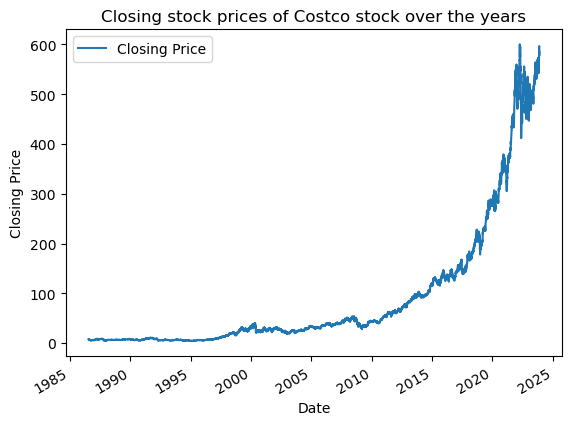

In [31]:
# Plotting the closing stock price data
closing_price_costco.plot()
plt.ylabel("Closing Price")
plt.title("Closing stock prices of Costco stock over the years")
plt.show()

In [32]:
combined_closing_price = pd.DataFrame()
difference = len(closing_price_walmart["Closing Price"]) - \
    len(closing_price_costco["Closing Price"])
combined_closing_price["closing_walmart"] = closing_price_walmart["Closing Price"].iloc[difference:]
combined_closing_price["closing_costco"] = closing_price_costco["Closing Price"]
combined_closing_price.head()

,closing_walmart,closing_costco
Date,,
1986-07-09 00:00:00-04:00,1.851545,7.599323
1986-07-10 00:00:00-04:00,1.842048,7.556142
1986-07-11 00:00:00-04:00,1.842048,7.297077
1986-07-14 00:00:00-04:00,1.751845,7.081185
1986-07-15 00:00:00-04:00,1.685379,6.865296


In [33]:
# Scale the data using MinMax scaling
combined_closing_price_scaled = scaler.fit_transform(combined_closing_price)
combined_closing_price_scaled.shape

(9420, 2)

In [34]:
# Function to generate train sample and test label sequences
def get_data_splits_for_multivariate(data, train_size=20, label_count=1):
    train_sets = []
    labels = []
    data_list = []
    for p in data:
        row = [num for num in p]
        data_list.append(row)
    length = len(data_list)
    # print(data_list)
    for i in range(0, length):
        if (i + train_size) >= length:
            break
        
        train_sets.append(data_list[i:(i + train_size)])
        labels.append([data_list[(i + train_size):(i + train_size + label_count)][0][0]])

    return np.array(train_sets).reshape(len(train_sets), train_size, 2), np.array(labels).reshape(len(labels), label_count, 1)

In [36]:
# Splitting the dataset
length_multivariate = len(combined_closing_price_scaled)
train_ratio = 0.60
val_ratio = 0.50

train_sample_count_multivariate = round(train_ratio * length_multivariate)
remaining_sample_count_multivariate = length_multivariate - train_sample_count_multivariate
val_sample_count_multivariate = round(val_ratio * remaining_sample_count_multivariate)

training_set_multivariate = combined_closing_price_scaled[:train_sample_count_multivariate]
validation_set_multivariate = combined_closing_price_scaled[
    train_sample_count_multivariate:train_sample_count_multivariate + val_sample_count_multivariate]
testing_set_multivariate = combined_closing_price_scaled[train_sample_count_multivariate + val_sample_count_multivariate:length_multivariate]

corresponding_y_costco_val = scaler.fit_transform(closing_price_costco)[
    train_sample_count_multivariate:train_sample_count_multivariate + val_sample_count_multivariate]
corresponding_y_costco_test = scaler.fit_transform(closing_price_costco)[
    train_sample_count_multivariate + val_sample_count_multivariate:length_multivariate]


In [37]:
train_size = 20
label_count = 1
X_train_combined, y_train_combined = get_data_splits_for_multivariate(
    training_set_multivariate, train_size, label_count)
X_val_combined, y_val_combined = get_data_splits_for_multivariate(
    validation_set_multivariate, train_size, label_count)
X_test_combined, y_test_combined = get_data_splits_for_multivariate(
    testing_set_multivariate, train_size, label_count)

In [38]:
multivariate_GRU = create_base_GRU(n_hidden_units, n_dense_units,
                                       (20, 2), activation='tanh')
multivariate_GRU.summary()

# Training the vanilla RNN
with tf.device('/cpu:0'):
    fitted_multivariate_GRU = multivariate_GRU.fit(
        X_train_combined, y_train_combined, validation_data=(X_val_combined, y_val_combined), batch_size=Batch_size, epochs=Epoch_count)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 64)                13056     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
176/176 [==============================] - 1s 3ms/step - loss: 3.4678e-04 - val_loss: 5.4125e-05
Epoch 2/50
176/176 [==============================] - 0s 2ms/step - loss: 1.5134e-05 - val_loss: 3.4934e-05
Epoch 3/50
176/176 [==============================] - 0s 2ms/step - loss: 1.4972e-05 - val_loss: 5.8249e-05
Epoch 4/50
176/176 [==============================] - 0s 2ms/step - loss: 1.3581e-05 - va

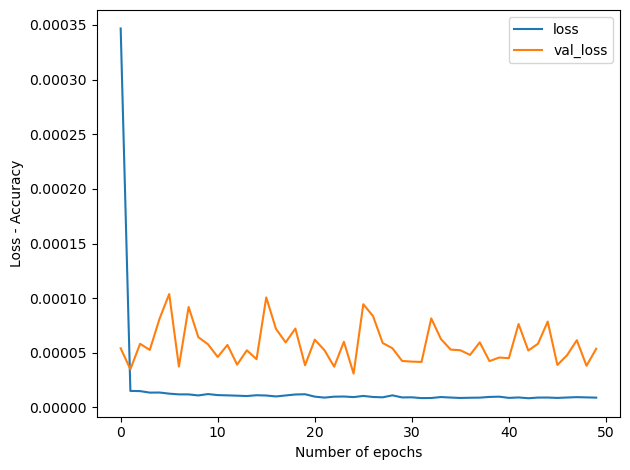

In [39]:
plot_training_history_curve(fitted_multivariate_GRU)

59/59 [==============================] - 0s 792us/step


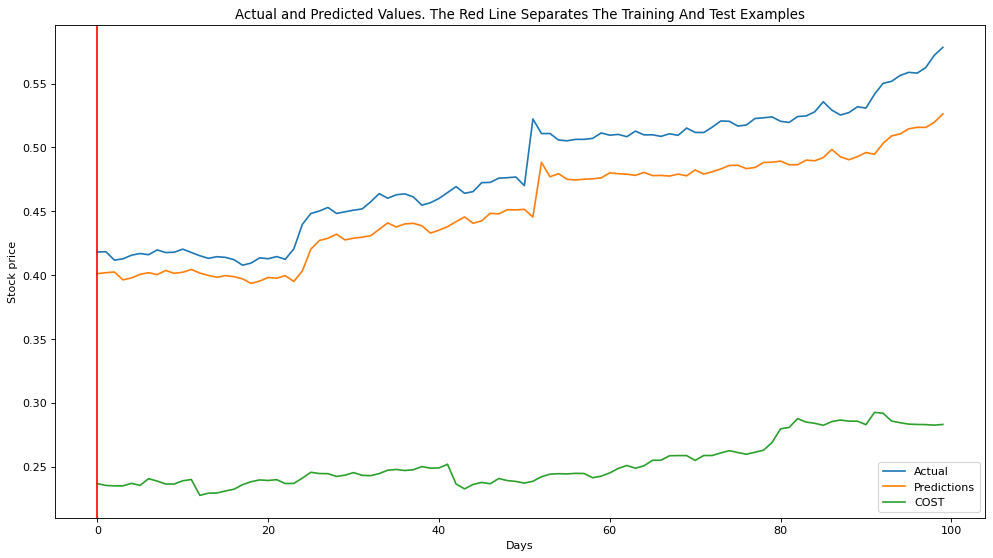

In [47]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_multivariate = fitted_multivariate_GRU.model.predict(X_train_combined)
    val_predict_multivariate = fitted_multivariate_GRU.model.predict(X_val_combined)
    test_predict_multivariate = fitted_multivariate_GRU.model.predict(X_test_combined)
plot_actual_vs_predicted_values(np.array([]), y_test_combined[300:400], np.array([]),
            test_predict_multivariate[300:400], corresponding_y_costco_test[300:400])

In [41]:
print("MSE for Multivariate train is:", mean_squared_error(
    y_train_combined.reshape(y_train_combined.shape[0], 1), train_predict_multivariate))
print("MSE for Multivariate val is:", mean_squared_error(
    y_val_combined.reshape(y_val_combined.shape[0], 1), val_predict_multivariate))
print("MSE for Multivariate test is:", mean_squared_error(
    y_test_combined.reshape(y_test_combined.shape[0], 1), test_predict_multivariate))

MSE for Multivariate train is: 7.86057046473013e-06
MSE for Multivariate val is: 5.373819858050186e-05
MSE for Multivariate test is: 0.00981377619423571


81/81 [==============================] - 0s 789us/step


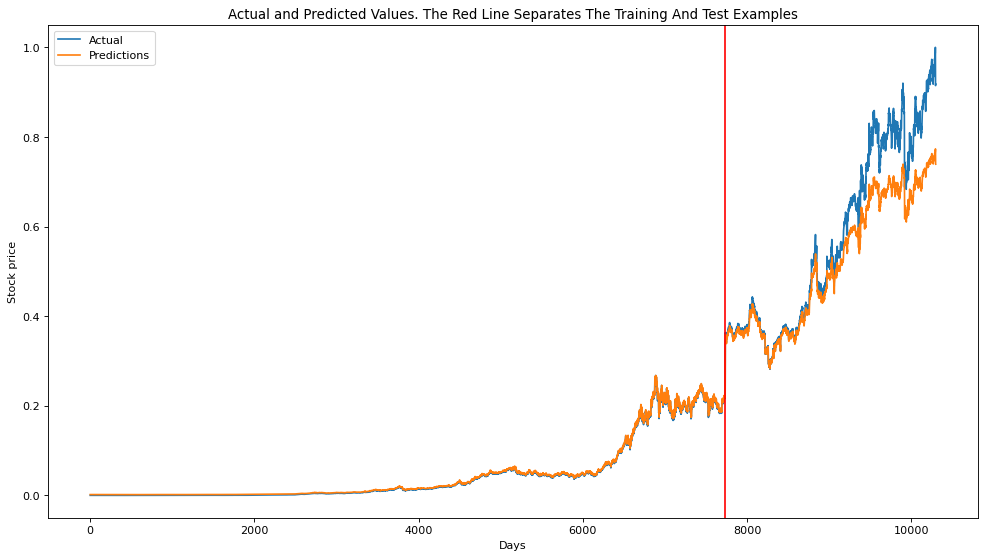

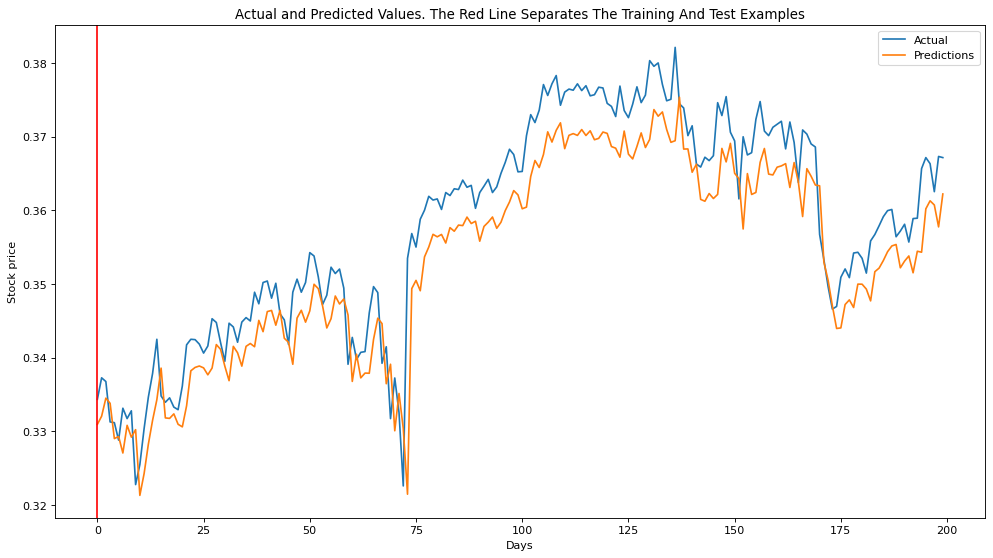

In [51]:
with tf.device('/cpu:0'):
    train_predict_gru_with_optimizer = fitted_optimized_gru_constant_lr.model.predict(
        X_train)
    test_predict_gru_with_optimizer = fitted_optimized_gru_constant_lr.model.predict(
        X_test)
plot_actual_vs_predicted_values(y_train, y_test, train_predict_gru_with_optimizer,
            test_predict_gru_with_optimizer)
plot_actual_vs_predicted_values(np.array([]), y_test[600:800], np.array([]),
            test_predict_gru_with_optimizer[600:800])